
# Bureau & Bureau Balance Analysis

## Overview

The **Bureau dataset** contains historical credit records for clients with financial institutions **other than Home Credit Group**, as reported by the national Credit Bureau. Each entry represents a unique loan or credit line associated with a customer prior to their application with Home Credit.

### How to Interpret Bureau Data

- Each client is identified by `SK_ID_CURR`, which links directly to the Application dataset.
- Each loan or credit product from another institution is represented by a unique `SK_ID_BUREAU`.
- Therefore, a single applicant (`SK_ID_CURR`) may have **multiple** bureau records (`SK_ID_BUREAU`), reflecting their full external credit history.

This structure allows us to analyze a customer's **credit behavior across institutions**, offering valuable insights into their financial reliability and risk profile—similar to how the Application dataset captures their current loan request and demographic details.

> *Note:* The Application dataset includes **307,511 records** and **122 features**, with the target variable `TARGET` indicating whether a loan was **repaid (0)** or **defaulted (1)**. This sets up a **binary classification problem** with notable class imbalance.

##  Goals of This Analysis

- Understand the distribution and quality of both categorical and numerical features  
- Identify missing values, anomalies, and rare categories  
- Explore relationships between features and the target variable  
- Detect redundant or low-impact features  
- Prepare insights for feature selection and model development

# Bureau & Bureau Balance Analysis

##  Structure of the Notebook

- [Data Loading and Preprocessing (Bureau)](#data-loading-and-preprocessing-bureau)
- [Bureau Dataset: Statistical Summary](#bureau-dataset-statistical-summary)  
  - [Data Types in Bureau Dataset](#data-types-in-bureau-dataset)
- [Bureau Coverage Check](#bureau-coverage-check)
- [Reduce Memory (Bureau)](#reduce-memory-bureau)
- [Missing Value Counts (Bureau)](#missing-value-counts-bureau)
- [Categorical Feature Summary](#categorical-feature-summary)
- [Target Integration for Feature Analysis](#target-integration-for-feature-analysis)

- [Exploring Categorical Features](#exploring-categorical-features)
  - [CREDIT_ACTIVE vs TARGET Analysis](#credit_active-vs-target-analysis)
  - [CREDIT_CURRENCY vs TARGET Analysis](#credit_currency-vs-target-analysis)
  - [CREDIT_TYPE vs TARGET Analysis](#credit_type-vs-target-analysis)

- [Observation: Categorical Features](#observation-categorical-features)
  - [Correlation Between Categorical Features and Target](#correlation-between-categorical-features-and-target)
  - [Observation: Categorical Feature Correlation with Target](#observation-categorical-feature-correlation-with-target)

- [Numeric Feature EDA](#numeric-feature-eda)
  - [Correlation with Target](#correlation-with-target)
  - [Observation: Numerical Feature Correlation (Phi k Heatmap)](#observation-numerical-feature-correlation-phi-k-heatmap)
  - [Distribution Analysis](#distribution-analysis)

- [Bureau Dataset Analysis Summary](#bureau-dataset-analysis-summary)


##  Bureau Balance Section

- [Data Loading and Preprocessing (Bureau Balance)](#data-loading-and-preprocessing-bureau-balance)
- [Bureau_balance Descriptive Statistics](#bureau_balance-descriptive-statistics)
- [Reduce Memory (Bureau Balance)](#reduce-memory-bureau-balance)
- [Bureau Balance Dataset Summary](#bureau-balance-dataset-summary)

##  Final Summary

 [Final Summary of Bureau & Bureau Balance Analysis](#final-summary-of-bureau--bureau-balance-analysis)

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [ ]:
import pandas as pd
import numpy as np
import polars as pl
import seaborn as sns


from src.utils.eda_utils import (
    reduce_memory_usage_pl,
    PhikCorrelationChecker,
    get_missing_percentages,
    get_categorical_columns,
    get_numerical_columns
    )
from src.utils.plot_utils import (
    draw_heatmap,
    barplot_feature_vs_target,
    plot_feature_vs_target_and_distribution,
    )

In [3]:
custom_palette = sns.color_palette(["#D89864", "#89ABC7"]) 

## Data Loading and Preprocessing

In [4]:
bureau_pl = pl.read_csv("../data/bureau.csv")
application_train = pl.read_csv("../data/application_train.csv")
bureau_pd = bureau_pl.to_pandas()

## Bureau Dataset: Statistical Summary

In [10]:
bureau_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             object 
dtypes: float64(7), int64(6), object(4)
memory usage: 222.6+ MB


### Data Types in Bureau Dataset

| Data Type | Count | Example Columns |
|-----------|-------|------------------|
| `int64`   | 6     | `SK_ID_CURR`, `DAYS_CREDIT`, `CNT_CREDIT_PROLONG` |
| `float64` | 7     | `AMT_CREDIT_SUM`, `DAYS_ENDDATE_FACT`, `AMT_CREDIT_SUM_DEBT` |
| `object`  | 4     | `CREDIT_ACTIVE`, `CREDIT_CURRENCY`, `CREDIT_TYPE`, `AMT_ANNUITY` |

**Note**: `AMT_ANNUITY` is stored as `object`, which likely indicates missing values or formatting issues.  
I think convert it to numeric.

In [11]:
bureau_pd.describe()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE
count,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1.716428e+06
mean,2.782149e+05,5.924434e+06,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,-5.937483e+02
std,1.029386e+05,5.322657e+05,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,7.207473e+02
min,1.000010e+05,5.000000e+06,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,-4.194700e+04
25%,1.888668e+05,5.463954e+06,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,-9.080000e+02
50%,2.780550e+05,5.926304e+06,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,-3.950000e+02
75%,3.674260e+05,6.385681e+06,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,-3.300000e+01
max,4.562550e+05,6.843457e+06,0.000000e+00,2.792000e+03,3.119900e+04,0.000000e+00,1.159872e+08,9.000000e+00,5.850000e+08,1.701000e+08,4.705600e+06,3.756681e+06,3.720000e+02


> **Note**: Many financial features have extreme outliers and skewed distributions. Most applicants have zero values for overdue and prolongation-related fields, indicating limited delinquency or credit extensions.

### Insights

- **Credit prolongation (`CNT_CREDIT_PROLONG`)** is rare — nearly all values are zero.
- **Debt and overdue amounts** show heavy skew — consider log transformation or binning.
- **Negative values** in `AMT_CREDIT_SUM_DEBT` and `AMT_CREDIT_SUM_LIMIT` may indicate data errors or special cases.
- **Credit update timing** (`DAYS_CREDIT_UPDATE`) suggests most records were updated within 2 years before application.

In [12]:
bureau_pd["AMT_ANNUITY"].value_counts()

AMT_ANNUITY
0.0          256915
4500.0         5182
13500.0        3147
22500.0        2502
9000.0         1725
              ...  
20667.555         1
3406.32           1
115033.5          1
3430.125          1
2096.235          1
Name: count, Length: 40321, dtype: int64

convert  feature `AMT_ANNUITY` datatype from object to numerical

In [5]:
bureau_pl = bureau_pl.with_columns(
    pl.col("AMT_ANNUITY").cast(pl.Float64).alias("AMT_ANNUITY")
)

## Bureau Coverage Check

Next, I evaluated how many applicants in the training dataset have corresponding records in the bureau dataset. This helps assess the completeness of external credit history data.

###  Checks Performed:
- **Current applications in training set**
- **Total number of credit bureau records**
- **Number of applicants with bureau information**
- **Number of applicants without bureau information**


In [15]:

bureau_ids = bureau_pl.select(pl.col('SK_ID_CURR').unique())
app_with_bureau = (
    application_train.join(bureau_ids, on='SK_ID_CURR', how='inner')
)

count_applicants = app_with_bureau.select(pl.len()).to_numpy()[0][0]

total_applicants = application_train['SK_ID_CURR'].n_unique()

applicants_with_bureau = (
    application_train.join(bureau_ids, on='SK_ID_CURR', how='inner')
)['SK_ID_CURR'].n_unique()

applicants_without_bureau = total_applicants - applicants_with_bureau
print('Count of Current application in train', total_applicants)
print('Count of credit bureau client', bureau_pl.shape[0])
print(f"Number of applicants with bureau information: {count_applicants}")
print(f"Applicants without bureau info: {applicants_without_bureau}")

duplicate_count  =  bureau_pd.shape[0] - bureau_pd.duplicated().shape[0]
print('Count of Duplicate count',duplicate_count)



Count of Current application in train 307511
Count of credit bureau client 1716428
Number of applicants with bureau information: 263491
Applicants without bureau info: 44020
Count of Duplicate count 0


## Reduce memory

In [6]:
bureau_pl = reduce_memory_usage_pl(bureau_pl)

Size before reduction: 233.63 MB
Initial data types: Counter({Float64: 8, Int64: 6, String: 3})
Size after reduction: 101.28 MB
Final data types: Counter({Float32: 8, Int32: 3, Categorical(ordering='physical'): 3, Int16: 2, Int8: 1})


This reduced the memory footprint of the dataset from 233.63 MB to 101.28 MB, significantly improving efficiency and paving the way for faster processing and model training.

##  Missing Value Counts

Missing values in a Dataset will affect model performances, to avoid that need to handle this problem for that I have various method , important method is Imputer for that first i need to check missing values details in this tables.

In [10]:
missing_data = get_missing_percentages(bureau_pl)
missing_data.sort('missing_percentage').tail(10)

feature,missing_percentage
str,f64
"""AMT_CREDIT_SUM_OVERDUE""",0.0
"""CREDIT_TYPE""",0.0
"""DAYS_CREDIT_UPDATE""",0.0
"""AMT_CREDIT_SUM""",0.000757
"""DAYS_CREDIT_ENDDATE""",6.149573
"""AMT_CREDIT_SUM_DEBT""",15.011932
"""AMT_CREDIT_SUM_LIMIT""",34.477415
"""DAYS_ENDDATE_FACT""",36.916958
"""AMT_CREDIT_MAX_OVERDUE""",65.513264


Out of 17 features, **7 contain missing values**, with `AMT_ANNUITY` having the highest at **over 70%**, which may require exclusion or imputation depending on its predictive value.

### Observations

1. `SK_ID_CURR` is the ID of the client's current loan with Home Credit.
2. `SK_ID_BUREAU` represents previous loans from other financial institutions. A single `SK_ID_CURR` may link to multiple `SK_ID_BUREAU` entries, reflecting the client's borrowing history.
3. Other features include credit-related metrics such as `DAYS_CREDIT`, `AMT_CREDIT_SUM`, etc.
4. Missing data is concentrated in financial amount and end-date fields, likely due to inactive or closed credit lines.


In [13]:
cat_col = get_categorical_columns(bureau_pl)
cat_col

['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']

In [14]:
bureau_pd[cat_col].describe()

,CREDIT_ACTIVE,CREDIT_CURRENCY,CREDIT_TYPE
count,1716428,1716428,1716428
unique,4,4,15
top,Closed,currency 1,Consumer credit
freq,1079273,1715020,1251615


##  Categorical Feature Summary

The bureau dataset contains three key categorical features. Here's a breakdown of their distribution and what it reveals:

### Feature Insights

#### 1. `CREDIT_ACTIVE`
- **Unique categories:** 4  
- **Most frequent value:** `Closed` (≈62.9% of records)  
- **Interpretation:** Majority of credit lines are no longer active, indicating that most bureau records refer to past loans.

#### 2. `CREDIT_CURRENCY`
- **Unique categories:** 4  
- **Most frequent value:** `currency 1` (≈99.9% of records)  
- **Interpretation:** Nearly all credit records are denominated in the same currency, suggesting minimal currency variation across institutions.

#### 3. `CREDIT_TYPE`
- **Unique categories:** 15  
- **Most frequent value:** `Consumer credit` (≈72.9% of records)  
- **Interpretation:** Consumer credit dominates the bureau data, reflecting the typical loan type clients engage in. Other types (e.g., mortgage, car loan) are present but less common.

---

### Key Findings
- The dataset is heavily skewed toward **closed consumer credit lines** in a **single currency**, which may influence feature importance and model generalization.
- The diversity in `CREDIT_TYPE` (15 categories) offers potential for segmentation or encoding strategies, but may require grouping rare types to avoid sparsity.

## Target Integration for Feature Analysis

Next, I merged the **target variable** from the training dataset into the bureau dataset. This allows us to explore how bureau-level features correlate with the target outcome.

By aligning each `SK_ID_CURR` with its corresponding target label, we can:
- Compare distributions of bureau features across target classes
- Identify potential predictive patterns in credit behavior


In [16]:
app_with_bureau = (
    application_train.join(bureau_ids, on='SK_ID_CURR', how='inner')
)
bureau_with_target = bureau_pl.join(app_with_bureau.select(['SK_ID_CURR','TARGET']), on='SK_ID_CURR', how='left')


In [18]:
bureau_with_target.head()

SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,TARGET
i32,i32,cat,cat,i16,i16,f32,f32,f32,i8,f32,f32,f32,f32,cat,i32,f32,i64
215354,5714462,"""Closed""","""currency 1""",-497,0,-153.0,-153.0,null,0,91323.0,0.0,null,0.0,"""Consumer credit""",-131,null,0
215354,5714463,"""Active""","""currency 1""",-208,0,1075.0,null,null,0,225000.0,171342.0,null,0.0,"""Credit card""",-20,null,0
215354,5714464,"""Active""","""currency 1""",-203,0,528.0,null,null,0,464323.5,null,null,0.0,"""Consumer credit""",-16,null,0
215354,5714465,"""Active""","""currency 1""",-203,0,null,null,null,0,90000.0,null,null,0.0,"""Credit card""",-16,null,0
215354,5714466,"""Active""","""currency 1""",-629,0,1197.0,null,77674.5,0,2.7e6,null,null,0.0,"""Consumer credit""",-21,null,0


In [19]:
bureau_pd_t = bureau_with_target.to_pandas()

In [20]:
def summarize_feature_target(df: pd.DataFrame, feature: str, target: str) -> pd.DataFrame:
    """
    Summarize how a categorical feature relates to the target variable.

    Returns:
    - DataFrame with columns: [feature, TARGET, total, Average]
    """
    target_0_counts = df[df[target] == 0][feature].value_counts().rename("TARGET")

    total_counts = df[feature].value_counts().rename("total")

    summary = pd.concat([target_0_counts, total_counts], axis=1).fillna(0)
    summary["Average"] = (summary["TARGET"] / summary["total"]) * 100
    summary = summary.reset_index().rename(columns={"index": feature})

    return summary[[feature, "TARGET", "total", "Average"]]

## Exploring  Categorical Features

### CREDIT_ACTIVE vs TARGET Analysis

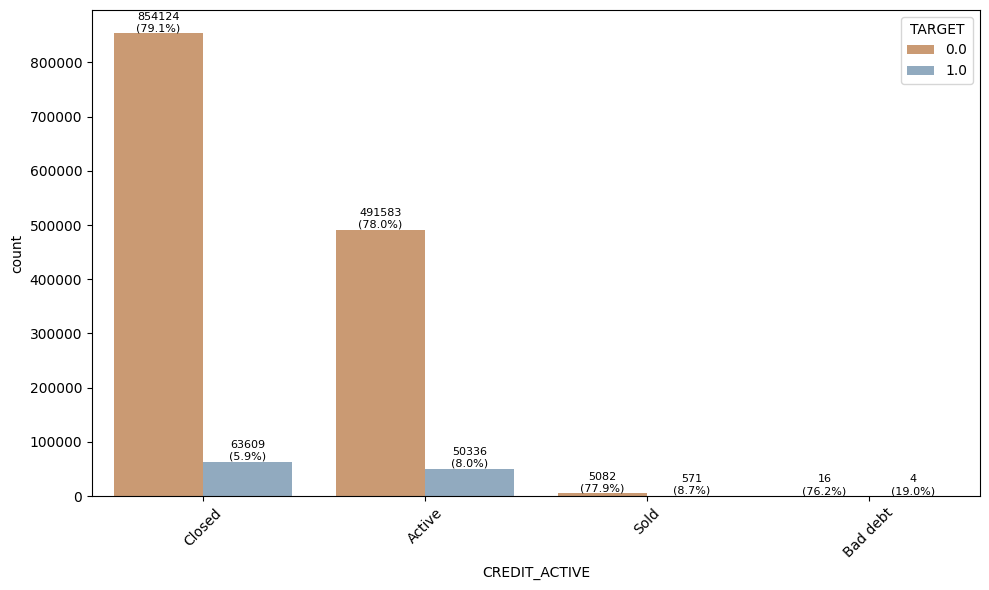

In [25]:

barplot_feature_vs_target(
        target = 'TARGET',
        df=bureau_pd_t,
        feature='CREDIT_ACTIVE',
        palette=custom_palette

        )

In [26]:
summary_df = summarize_feature_target(bureau_pd_t, "CREDIT_ACTIVE", "TARGET")
print(summary_df)

  CREDIT_ACTIVE  TARGET    total    Average
0        Closed  854124  1079273  79.138828
1        Active  491583   630607  77.953940
2          Sold    5082     6527  77.861192
3      Bad debt      16       21  76.190476


### Key Findings

- **Closed credits** are the most common and show the highest repayment rate (~79.1%). This suggests that applicants with completed credit histories tend to be more reliable.
- **Active credits** are still ongoing and show slightly lower repayment behavior (~77.95%), possibly indicating current financial obligations.
- **Sold credits** (transferred to another institution) and **bad debt** categories are rare but show even lower repayment rates.
- **Bad debt** has the lowest repayment rate (~76.2%) and may signal high-risk applicants, though the sample size is very small.

### CREDIT_CURRENCY vs TARGET Analysis

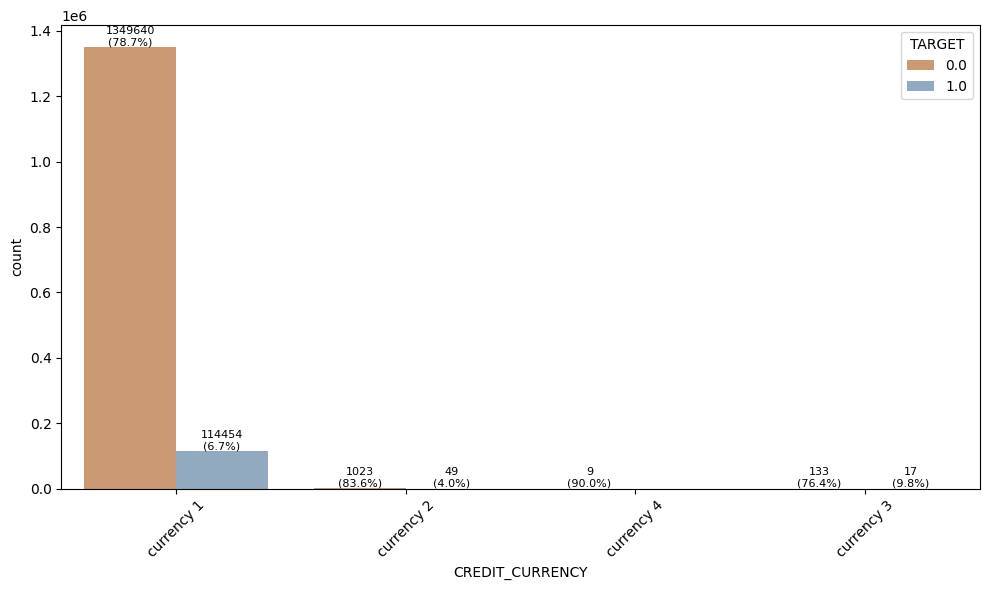

In [27]:
barplot_feature_vs_target(
        target = 'TARGET',
        df=bureau_pd_t,
        feature='CREDIT_CURRENCY',
        palette=custom_palette
        )

In [28]:
	
summary_df = summarize_feature_target(bureau_pd_t, "CREDIT_CURRENCY", "TARGET")
print(summary_df)

  CREDIT_CURRENCY   TARGET    total    Average
0      currency 1  1349640  1715020  78.695292
1      currency 2     1023     1224  83.578431
2      currency 3      133      174  76.436782
3      currency 4        9       10  90.000000


### Key Findings
- **Currency 1** dominates the dataset and shows a solid repayment rate (~78.7%), making it the baseline for comparison.
- **Currency 2** has a higher repayment rate (~83.6%) despite its small sample size, which may suggest more reliable borrowers or niche lending conditions.
- **Currency 3** shows a lower repayment rate (~76.4%), possibly indicating higher risk or less favorable lending terms.
- **Currency 4** has the highest repayment rate (90%), but with only 10 records, it's statistically insignificant for generalization.

### CREDIT_TYPE' vs TARGET Analysis

In [29]:
summary_df = summarize_feature_target(bureau_pd_t, 'CREDIT_TYPE', "TARGET")
print(summary_df)

                                     CREDIT_TYPE  TARGET    total     Average
0                                Consumer credit  989564  1251615   79.062971
1                                    Credit card  313591   402195   77.969890
2                                       Car loan   22433    27690   81.014807
3                                       Mortgage   14827    18391   80.620956
4                                      Microloan    7146    12413   57.568678
5                  Loan for business development    1615     1975   81.772152
6                           Another type of loan     793     1017   77.974435
7                           Unknown type of loan     443      555   79.819820
8         Loan for working capital replenishment     329      469   70.149254
9                               Real estate loan      23       27   85.185185
10                     Cash loan (non-earmarked)      22       56   39.285714
11            Loan for the purchase of equipment      13       1

### Key Findings

- **Consumer credit** and **credit cards** dominate the dataset and show solid repayment rates (~79%), making them reliable benchmarks.
- **Car loans**, **mortgages**, and **business development loans** all show **above-average repayment rates** (≥80%), suggesting lower risk profiles.
- **Microloans** stand out with a **significantly lower repayment rate (~57.6%)**, indicating higher risk and potential financial vulnerability among borrowers.
- **Cash loans (non-earmarked)** have the **lowest repayment rate (~39.3%)**, which may reflect unstructured lending or emergency borrowing behavior.
- **Real estate loans** and niche types like **margin lending**, **mobile operator loans**, and **interbank credit** show **very high repayment rates**, but their sample sizes are too small for reliable conclusions.

next, I group feature  

In [23]:
credit_type_mapping = {
    'Consumer credit': 'Personal Loans',
    'Credit card': 'Personal Loans',
    'Car loan': 'Vehicle Loans',
    'Mortgage': 'Real Estate Loans',
    'Microloan': 'Other Loans',
    'Loan for business development': 'Business Loans',
    'Another type of loan': 'Other Loans',
    'Unknown type of loan': 'Other Loans',
    'Loan for working capital replenishment': 'Business Loans',
    'Real estate loan': 'Real Estate Loans',
    'Cash loan (non-earmarked)': 'Personal Loans',
    'Loan for the purchase of equipment': 'Business Loans',
    'Loan for purchase of shares (margin lending)': 'Investment Loans',
    'Mobile operator loan': 'Other Loans',
    'Interbank credit': 'Other Loans'
}


bureau_pd_t['credit_group'] =bureau_pd_t['CREDIT_TYPE'].map(credit_type_mapping)

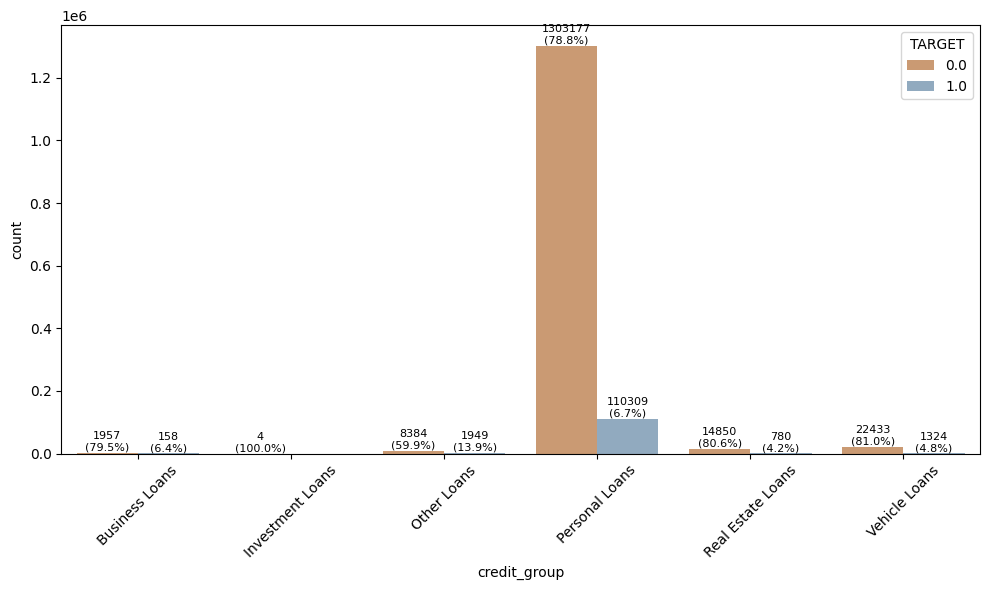

In [24]:
barplot_feature_vs_target(
        target = 'TARGET',
        df=bureau_pd_t,
        feature='credit_group',
        palette=custom_palette
        )

## Observation: Categorical Features

#### Credit Active
1. Applicants who **did not default** tend to have **closed previous credit records**, indicating responsible financial behavior. This increases their chances of loan approval.
2. In contrast, **defaulters are overrepresented in the 'Bad debt' category**, suggesting poor repayment history. These clients are less likely to be approved for new loans.

#### Credit Currency
- Applicants with **Currency 4** show the **highest repayment rate (90%)**, implying that loans issued in this currency are more likely to be repaid. However, the sample size is small, so this insight should be treated cautiously.

#### Credit Type
- **Real estate loans** show an **exceptionally high repayment rate (85.2%)**, with 23 out of 27 applicants repaying successfully. This suggests that borrowers taking real estate loans are highly reliable.

### Correlation Between Categorical Features and Target

Next, I examine how each categorical feature is correlated with the `TARGET` variable. This helps identify which categories are strong indicators of loan repayment behavior and can be valuable for predictive modeling.


In [ ]:
cat_checker  = PhikCorrelationChecker(
    bureau_pd_t[cat_col +['TARGET']],
    target_col='TARGET'
)

In [26]:
cat_corr = cat_checker.get_correlations()

interval columns not set, guessing: ['TARGET']


In [27]:
sorted_corr = cat_corr.sort_values(by='phik_correlation', ascending=False)
sorted_corr

,feature,phik_correlation
0,CREDIT_ACTIVE,0.064480
2,CREDIT_TYPE,0.049955
1,CREDIT_CURRENCY,0.004993


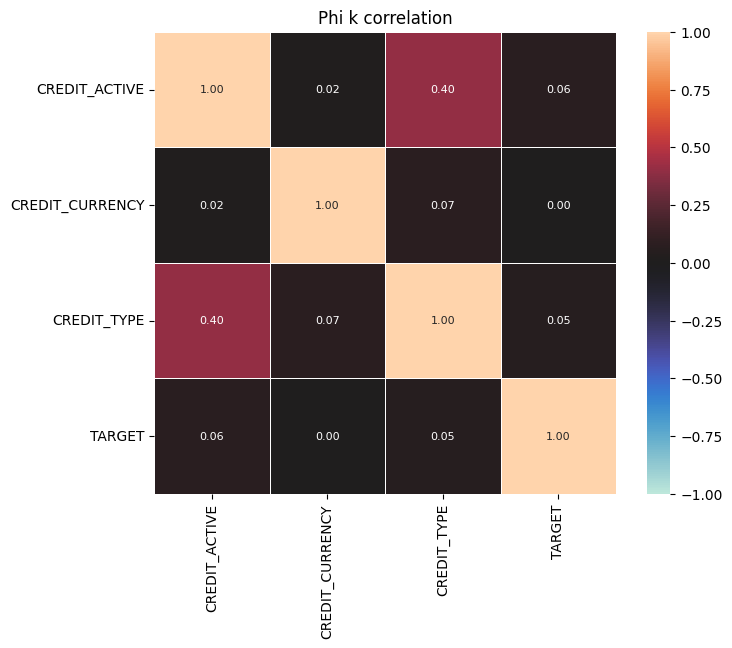

In [28]:
draw_heatmap(
    data=cat_checker.phik_matrix,
    annot=True,
    annot_kws={'size':8},
    title='Phi k correlation',
    vmin=-1,
    vmax=1,
    fmt=".2f",
    cmap="icefire",
    square=True)

In [36]:
independed_feature_corr = cat_checker.get_feature_feature_correlations()
independed_feature_corr


,feature_1,feature_2,phik_correlation
0,CREDIT_ACTIVE,CREDIT_CURRENCY,0.021107
1,CREDIT_ACTIVE,CREDIT_TYPE,0.402079
2,CREDIT_ACTIVE,TARGET,0.064480
3,CREDIT_CURRENCY,CREDIT_TYPE,0.073225
4,CREDIT_CURRENCY,TARGET,0.004993
5,CREDIT_TYPE,TARGET,0.049955


### Observation: Categorical Feature Correlation with Target

Based on the Phi k correlation matrix:

- **CREDIT_CURRENCY** shows **very weak correlation** with the `TARGET` variable, indicating it has limited predictive value.
- **CREDIT_TYPE** and **CREDIT_ACTIVE** also exhibit **low correlation** with `TARGET`, suggesting these features alone may not strongly influence repayment behavior.
- However, **CREDIT_ACTIVE and CREDIT_TYPE** show a **moderate correlation (0.40)** with each other, which may reflect overlapping behavioral patterns or institutional lending practices.

>These findings suggest that while individual categorical features may not be strongly predictive of default risk, their interactions or aggregated patterns could still offer value in feature engineering.

### Numeric Feature EDA

In [30]:
num_cols = bureau_pd_t.drop(columns=['SK_ID_CURR', 'SK_ID_BUREAU']).select_dtypes(include='number').columns.to_list()
num_cols

['DAYS_CREDIT',
 'CREDIT_DAY_OVERDUE',
 'DAYS_CREDIT_ENDDATE',
 'DAYS_ENDDATE_FACT',
 'AMT_CREDIT_MAX_OVERDUE',
 'CNT_CREDIT_PROLONG',
 'AMT_CREDIT_SUM',
 'AMT_CREDIT_SUM_DEBT',
 'AMT_CREDIT_SUM_LIMIT',
 'AMT_CREDIT_SUM_OVERDUE',
 'DAYS_CREDIT_UPDATE',
 'AMT_ANNUITY',
 'TARGET']


###  Correlation with Target
first, I check corelation numerical feature

In [31]:
num_checker  = PhikCorrelationChecker(
    bureau_pd_t[num_cols],
    target_col='TARGET'
)

In [32]:
bureau_pd_t[num_cols]

,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,TARGET
0,-497,0,-153.0,-153.0,NaN,0,9.132300e+04,0.0,NaN,0.0,-131,NaN,0.0
1,-208,0,1075.0,NaN,NaN,0,2.250000e+05,171342.0,NaN,0.0,-20,NaN,0.0
2,-203,0,528.0,NaN,NaN,0,4.643235e+05,NaN,NaN,0.0,-16,NaN,0.0
3,-203,0,NaN,NaN,NaN,0,9.000000e+04,NaN,NaN,0.0,-16,NaN,0.0
4,-629,0,1197.0,NaN,77674.5,0,2.700000e+06,NaN,NaN,0.0,-21,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,-44,0,-30.0,NaN,0.0,0,1.125000e+04,11250.0,0.0,0.0,-19,NaN,1.0
1716424,-2648,0,-2433.0,-2493.0,5476.5,0,3.813084e+04,0.0,0.0,0.0,-2493,NaN,0.0
1716425,-1809,0,-1628.0,-970.0,NaN,0,1.557000e+04,NaN,NaN,0.0,-967,NaN,0.0
1716426,-1878,0,-1513.0,-1513.0,NaN,0,3.600000e+04,0.0,0.0,0.0,-1508,NaN,0.0


In [33]:
num_corr = num_checker.get_correlations()

interval columns not set, guessing: ['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY', 'TARGET']


In [34]:
sorted_corr = num_corr.sort_values(by='phik_correlation', ascending=False)
sorted_corr

,feature,phik_correlation
0,DAYS_CREDIT,0.088648
2,DAYS_CREDIT_ENDDATE,0.018997
9,AMT_CREDIT_SUM_OVERDUE,0.005654
8,AMT_CREDIT_SUM_LIMIT,0.005107
4,AMT_CREDIT_MAX_OVERDUE,0.004280
5,CNT_CREDIT_PROLONG,0.003862
1,CREDIT_DAY_OVERDUE,0.002528
10,DAYS_CREDIT_UPDATE,0.002158
7,AMT_CREDIT_SUM_DEBT,0.001695
3,DAYS_ENDDATE_FACT,0.000000


In [35]:
sorted_corr[sorted_corr['phik_correlation'] <= 0.01].sort_values(by='phik_correlation', ascending=False)['feature'].to_list()

['AMT_CREDIT_SUM_OVERDUE',
 'AMT_CREDIT_SUM_LIMIT',
 'AMT_CREDIT_MAX_OVERDUE',
 'CNT_CREDIT_PROLONG',
 'CREDIT_DAY_OVERDUE',
 'DAYS_CREDIT_UPDATE',
 'AMT_CREDIT_SUM_DEBT',
 'DAYS_ENDDATE_FACT',
 'AMT_CREDIT_SUM',
 'AMT_ANNUITY']

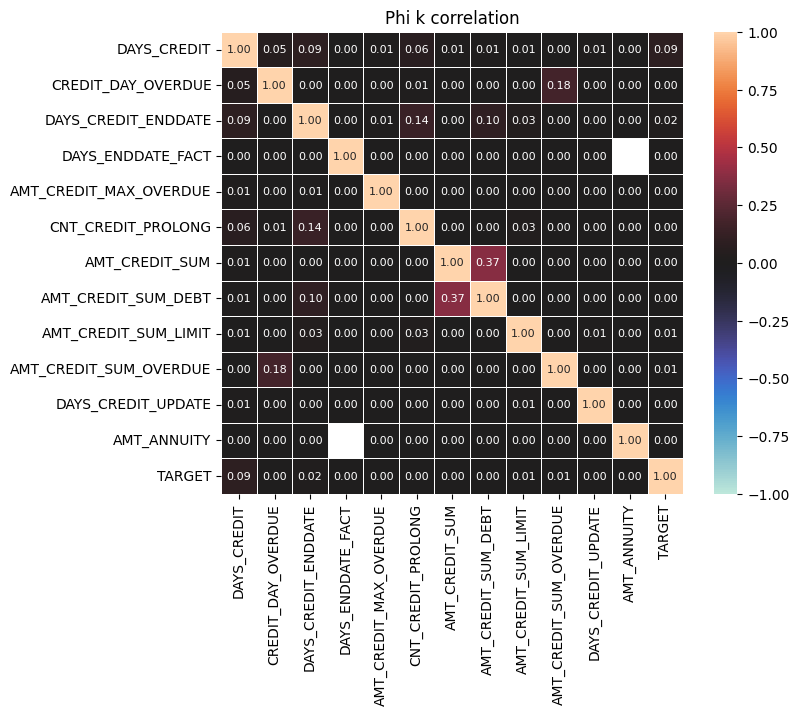

In [36]:
draw_heatmap(
    data=num_checker.phik_matrix,
    annot=True,
    annot_kws={'size':8},
    title='Phi k correlation',
    vmin=-1,
    vmax=1,
    fmt=".2f",
    cmap="icefire",
    square=True)

### Observation: Numerical Feature Correlation (Phi k Heatmap)

#### Strong Correlations
- **AMT_CREDIT_SUM ↔ AMT_CREDIT_SUM_DEBT**: Very strong correlation (**0.97**), indicating that the total credit amount is closely tied to the debt amount.
- **AMT_CREDIT_SUM ↔ AMT_CREDIT_SUM_LIMIT**: High correlation (**0.89**), suggesting that credit limits are often proportional to the total credit issued.
- **AMT_CREDIT_SUM_DEBT ↔ AMT_CREDIT_SUM_LIMIT**: Moderate correlation (**0.70**), showing a relationship between debt and credit limit.

#### Moderate Relationships
- **DAYS_CREDIT ↔ DAYS_CREDIT_ENDDATE / DAYS_ENDDATE_FACT**: These time-based features show moderate associations, possibly reflecting credit duration and repayment timelines.

#### Weak or No Correlation with Target
- Most features, including **AMT_ANNUITY**, **AMT_CREDIT_UPDATE**, and **CNT_CREDIT_PROLONG**, show **low correlation with `TARGET`**, suggesting limited direct predictive power.
- **TARGET** itself has weak associations across the board, reinforcing the need for feature engineering or interaction terms to improve model performance.

#### Other Notes
- **Diagonal values** are all 1.00, as expected (self-correlation).
- **CREDIT_DAY_OVERDUE** and **AMT_CREDIT_MAX_OVERDUE** show weak correlations with other features, possibly due to sparse or skewed data.


In [44]:
bureau_pd_t[num_cols[:-1]].corr()

,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
DAYS_CREDIT,1.000000,-0.027266,0.225682,0.875359,-0.014724,-0.030460,0.050883,0.135397,0.025140,-0.000383,0.688771,0.005676
CREDIT_DAY_OVERDUE,-0.027266,1.000000,-0.007352,-0.008637,0.001249,0.002756,-0.003292,-0.002355,-0.000345,0.090951,-0.018461,-0.000339
DAYS_CREDIT_ENDDATE,0.225682,-0.007352,1.000000,0.248825,0.000577,0.113683,0.055424,0.081298,0.095421,0.001077,0.248525,0.000475
DAYS_ENDDATE_FACT,0.875359,-0.008637,0.248825,1.000000,0.000999,0.012017,0.059096,0.019609,0.019476,-0.000332,0.751294,0.006274
AMT_CREDIT_MAX_OVERDUE,-0.014724,0.001249,0.000577,0.000999,1.000000,0.001523,0.081663,0.014007,-0.000112,0.015036,-0.000749,0.001578
CNT_CREDIT_PROLONG,-0.030460,0.002756,0.113683,0.012017,0.001523,1.000000,-0.008345,-0.001366,0.073805,0.000002,0.017864,-0.000465
AMT_CREDIT_SUM,0.050883,-0.003292,0.055424,0.059096,0.081663,-0.008345,1.000000,0.683419,0.003756,0.006342,0.104629,0.049146
AMT_CREDIT_SUM_DEBT,0.135397,-0.002355,0.081298,0.019609,0.014007,-0.001366,0.683419,1.000000,-0.018215,0.008046,0.141235,0.025507
AMT_CREDIT_SUM_LIMIT,0.025140,-0.000345,0.095421,0.019476,-0.000112,0.073805,0.003756,-0.018215,1.000000,-0.000687,0.046028,0.004392
AMT_CREDIT_SUM_OVERDUE,-0.000383,0.090951,0.001077,-0.000332,0.015036,0.000002,0.006342,0.008046,-0.000687,1.000000,0.003528,0.000344


In [45]:
num_cols[:-1]

['DAYS_CREDIT',
 'CREDIT_DAY_OVERDUE',
 'DAYS_CREDIT_ENDDATE',
 'DAYS_ENDDATE_FACT',
 'AMT_CREDIT_MAX_OVERDUE',
 'CNT_CREDIT_PROLONG',
 'AMT_CREDIT_SUM',
 'AMT_CREDIT_SUM_DEBT',
 'AMT_CREDIT_SUM_LIMIT',
 'AMT_CREDIT_SUM_OVERDUE',
 'DAYS_CREDIT_UPDATE',
 'AMT_ANNUITY']

Get person correlation

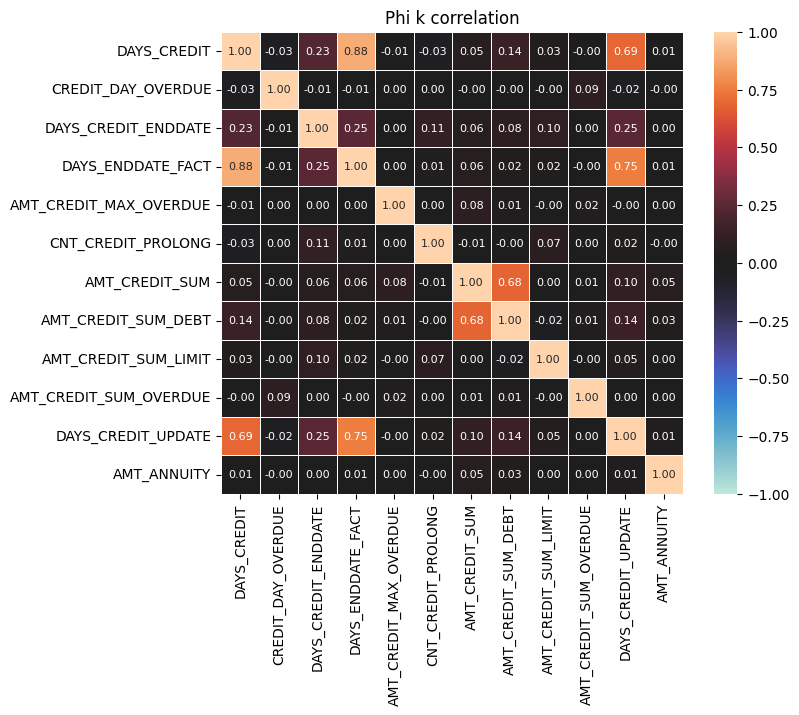

In [46]:
draw_heatmap(
    data=bureau_pd_t[num_cols[:-1]].corr(),
    annot=True,
    annot_kws={'size':8},
    title='Phi k correlation',
    vmin=-1,
    vmax=1,
    fmt=".2f",
    cmap="icefire",
    square=True)

In [47]:
independed_feature_corr = num_checker.get_feature_feature_correlations()
independed_feature_corr.sort_values(by='phik_correlation', ascending=False)


,feature_1,feature_2,phik_correlation
57,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,0.374357
19,CREDIT_DAY_OVERDUE,AMT_CREDIT_SUM_OVERDUE,0.177859
25,DAYS_CREDIT_ENDDATE,CNT_CREDIT_PROLONG,0.140198
27,DAYS_CREDIT_ENDDATE,AMT_CREDIT_SUM_DEBT,0.097634
1,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,0.092299
...,...,...,...
73,AMT_CREDIT_SUM_OVERDUE,AMT_ANNUITY,0.000000
72,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,0.000000
75,DAYS_CREDIT_UPDATE,AMT_ANNUITY,0.000000
77,AMT_ANNUITY,TARGET,0.000000


###  Distribution Analysis
Next, I check numerical data distribution and how it campare with Target


### DAYS_CREDIT Analysis

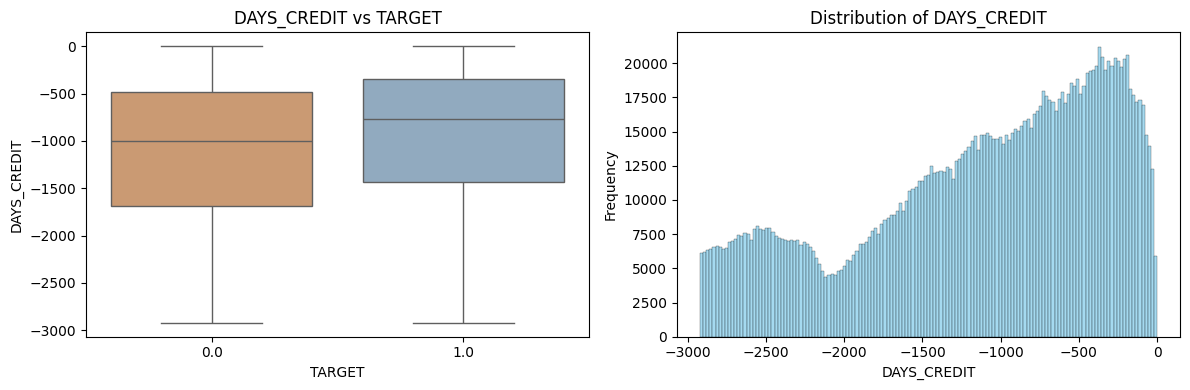

In [37]:
plot_feature_vs_target_and_distribution(
        bureau_pd_t,
        feature='DAYS_CREDIT',
        target='TARGET',
        palette=custom_palette,
    )

### Observation: DAYS_CREDIT Analysis

#### Boxplot (DAYS_CREDIT vs TARGET)
- The distribution of `DAYS_CREDIT` is **similar across both TARGET classes (0 and 1)**.
- Median values for both classes hover around **-1000 days**, with comparable interquartile ranges.
- This suggests that **DAYS_CREDIT alone may not be a strong discriminator** between default and non-default cases.

#### Histogram (Distribution of DAYS_CREDIT)
- The distribution is **right-skewed**, with most values concentrated between **-3000 and 0 days**.
- A noticeable **peak near -500 days** indicates a common credit age among applicants.
- The frequency increases as values approach 0, implying **more recent credit activity** is common.

Overall, while `DAYS_CREDIT` reflects meaningful behavioral patterns, its weak separation across TARGET classes suggests it may be more useful when combined with other features or transformed into categorical bins 

### DAYS_CREDIT Analysis

To improve readability, I will convert the DAYS_CREDIT feature from days to years

In [39]:
bureau_pd_t['YEAR_CREDIT'] = bureau_pd_t['DAYS_CREDIT']/-365

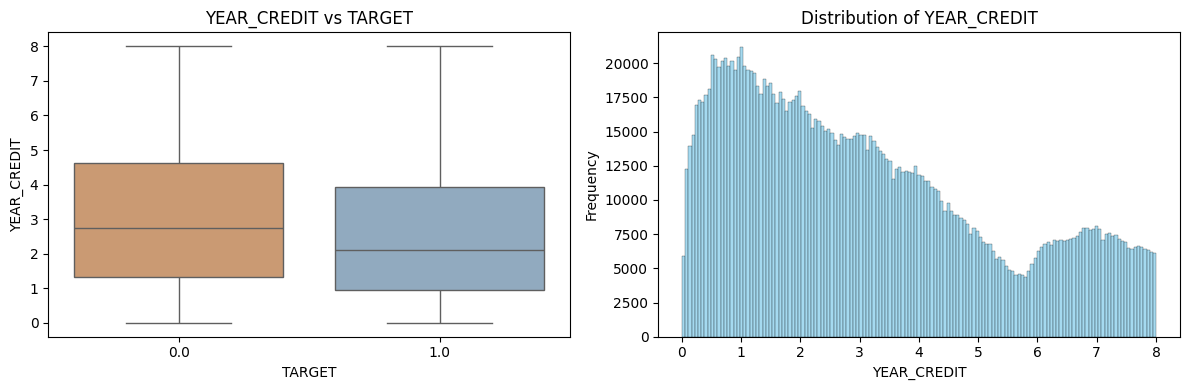

In [40]:
plot_feature_vs_target_and_distribution(
        bureau_pd_t,
        feature='YEAR_CREDIT',
        target='TARGET',
        palette=custom_palette,
    )

### Observation: YEAR_CREDIT vs TARGET

#### Boxplot Analysis
- The **median `YEAR_CREDIT`** is slightly **higher for TARGET = 0** (non-default) than for TARGET = 1 (default).
- Both groups show **similar spread and interquartile ranges**, suggesting that credit age alone does not strongly differentiate default risk.
- A few **outliers** are present in both categories, especially for TARGET = 1, indicating some applicants with unusually long credit histories.

#### Distribution Analysis
- The histogram reveals that most applicants have a **credit age between 0 and 4 years**, with a **peak around 1 year**.
- There’s a **secondary bump** around 6–7 years, possibly reflecting a subset of long-term borrowers.
- The overall distribution is **right-skewed**, with fewer applicants having credit histories longer than 7 years.

 These insights suggest that while `YEAR_CREDIT` reflects applicant credit history, it may not be a strong standalone predictor of default. However, it could be useful when combined with other behavioral or financial features.

### DAYS_CREDIT_ENDDATE Analysis

To improve readability, I will convert the DAYS_CREDIT_ENDDATE feature from days to years

In [52]:
bureau_pd_t['YEAR_CREDIT_ENDDATE'] = bureau_pd_t['DAYS_CREDIT_ENDDATE']/365

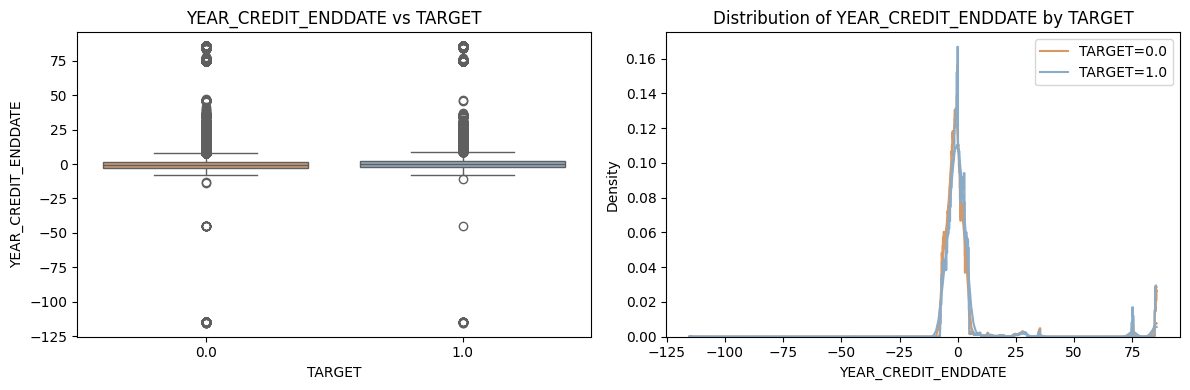

In [53]:
plot_feature_vs_target_and_distribution(
        bureau_pd_t,
        feature='YEAR_CREDIT_ENDDATE',
        target='TARGET',
        palette=custom_palette,
    )

In [54]:
bureau_pd_t['YEAR_CREDIT_ENDDATE'].describe().T

count    1.610875e+06
mean     1.398678e+00
std      1.368279e+01
min     -1.152329e+02
25%     -3.117808e+00
50%     -9.041096e-01
75%      1.298630e+00
max      8.547672e+01
Name: YEAR_CREDIT_ENDDATE, dtype: float64

### Observation: YEAR_CREDIT_ENDDATE vs TARGET

#### Boxplot Analysis
- The **distribution of `YEAR_CREDIT_ENDDATE`** is nearly identical for both TARGET classes (0 and 1).
- Median values and interquartile ranges are similar, with **no significant separation** between default and non-default groups.
- A few **outliers** exist in both categories, but they do not appear to influence the overall trend.

#### Density Plot Analysis
- The **density curves for TARGET = 0 and TARGET = 1** are almost perfectly overlapping.
- This indicates that the **credit end date is distributed similarly** regardless of repayment status.

Overall, `YEAR_CREDIT_ENDDATE` does not show meaningful differentiation between default and non-default cases. It may have limited standalone predictive power, but could still be useful in combination with other time-based features.

### DAYS_ENDDATE_FACT Analysis

To improve readability, I will convert the DAYS_ENDDATE_FACT feature from days to years

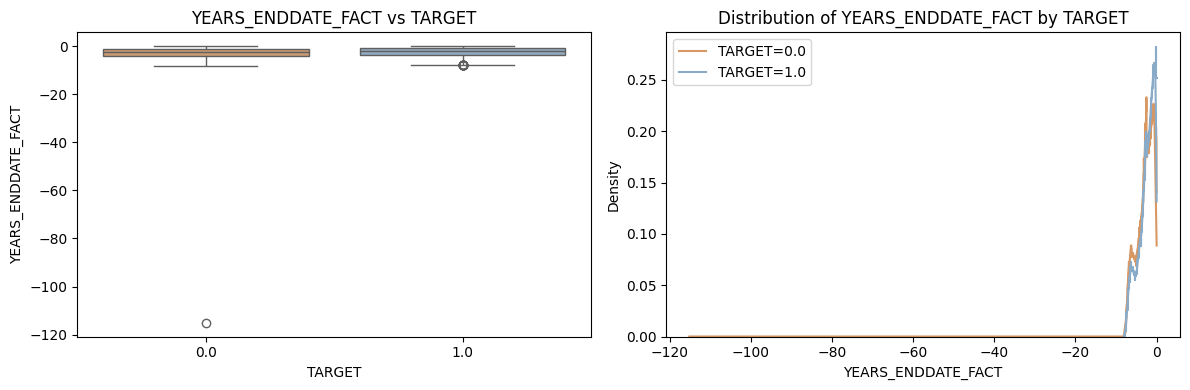

In [56]:
plot_feature_vs_target_and_distribution(
        bureau_pd_t,
        feature='YEARS_ENDDATE_FACT',
        target='TARGET',
        palette=custom_palette,
    )

### bservation: YEARS_ENDDATE_FACT vs TARGET

The analysis of `YEARS_ENDDATE_FACT` reveals the following:

- The **boxplot** shows a significant outlier below –100 years, which is far outside the normal range of credit end dates.
- The **density plot** confirms this anomaly with a sharp spike near –116 years, suggesting a data entry error or placeholder value.

This extreme value distorts the distribution and could negatively impact model performance or statistical analysis.

### Recommendation
Similar to `DAYS_CREDIT_ENDDATE`, we observe an error value of **116 years** in `DAYS_ENDDATE_FACT`.  
**Removing or filtering out this value** will improve data quality and ensure more reliable insights.

### DAYS_CREDIT_UPDATE Analysis

To improve readability, I will convert the DAYS_CREDIT_UPDATE feature from days to years

In [41]:
bureau_pd_t['YEARS_CREDIT_UPDATE'] = bureau_pd_t['DAYS_CREDIT_UPDATE']/365

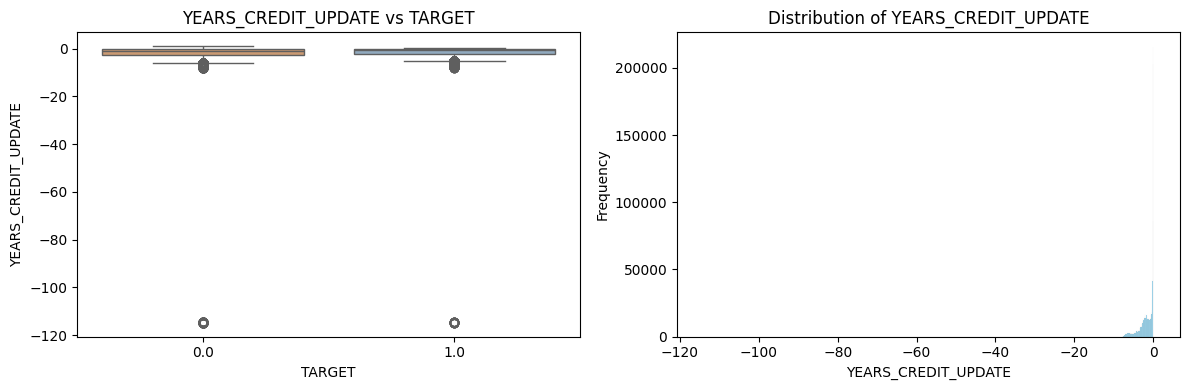

In [42]:
plot_feature_vs_target_and_distribution(
        bureau_pd_t,
        feature='YEARS_CREDIT_UPDATE',
        target='TARGET',
        palette=custom_palette,
    )

### Observation: YEARS_CREDIT_UPDATE vs TARGET

- The **boxplot** shows that both TARGET groups (0 and 1) have similar distributions of `YEARS_CREDIT_UPDATE`, with median values close to zero.
- There are noticeable **outliers below –100 years**, which are likely erroneous entries or placeholder values.
- The **histogram** reveals a sharp concentration of values near zero, with a long left tail indicating a few extreme negative values.

### Recommendation
Similar to `DAYS_CREDIT_ENDDATE`, we observe an error value of **116 years** in `DAYS_ENDDATE_FACT`.  
**Removing this value** will make sense and help improve the integrity of the dataset.

### AMT_CREDIT_SUM_LIMIT Analysis

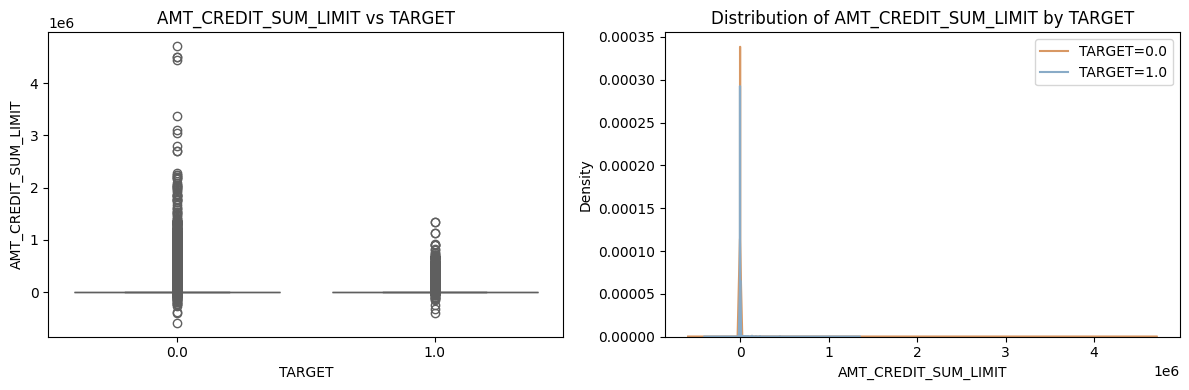

In [59]:
plot_feature_vs_target_and_distribution(
        bureau_pd_t,
        feature= 'AMT_CREDIT_SUM_LIMIT',
        target='TARGET',
        palette=custom_palette,
    )

## Observation: AMT_CREDIT_SUM_LIMIT vs TARGET

- The **scatter plot** shows that most values of `AMT_CREDIT_SUM_LIMIT` are concentrated at the lower end, regardless of `TARGET` value.
- A few **extreme outliers** exceed 3,000,000, which may skew the distribution and affect model sensitivity.
- The **density plot** reveals that both `TARGET=0` and `TARGET=1` groups have nearly identical distributions, heavily concentrated at lower credit limits.

### Recommendation
There is no strong visual separation between the two target groups in terms of `AMT_CREDIT_SUM_LIMIT`.  
However, it’s worth investigating the **extreme outliers** further, as they may represent data entry errors or rare cases.  
Removing or capping these values could improve model robustness and reduce noise.

### AMT_CREDIT_SUM_OVERDUE Analysis

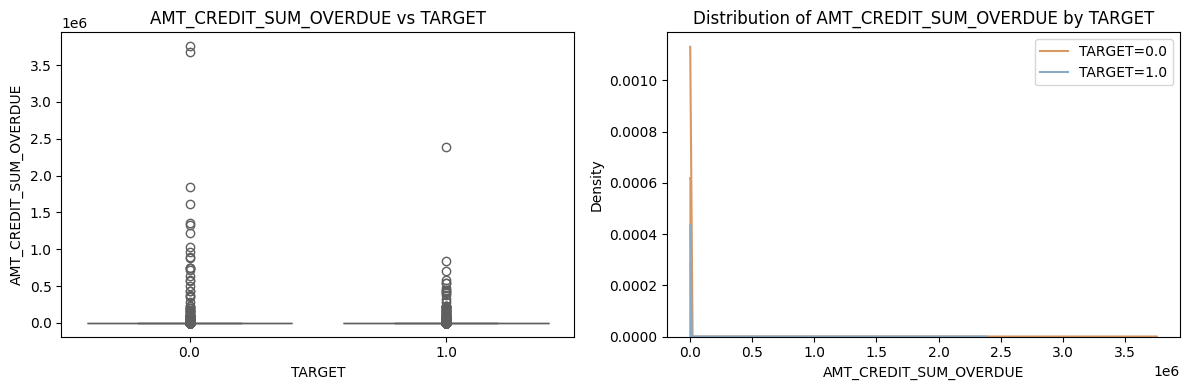

In [60]:
plot_feature_vs_target_and_distribution(
        bureau_pd_t,
        feature= 'AMT_CREDIT_SUM_OVERDUE',
        target='TARGET',
        palette=custom_palette,
    )

### Observation: AMT_CREDIT_SUM_OVERDUE vs TARGET

- The **scatter plot** shows that most values of `AMT_CREDIT_SUM_OVERDUE` are concentrated near zero for both TARGET groups, with a few extreme outliers reaching significantly high overdue amounts.
- The **density plot** confirms that the distribution is heavily skewed to the left, indicating that the majority of clients have little to no overdue credit.
- There is **no strong visual separation** between TARGET=0 and TARGET=1 groups, suggesting that this feature alone may not be a strong predictor of default risk.


## Bureau Dataset Analysis Summary

### 1. Dataset Overview
- Total Features: 17
- Data Types:
    - int64: 6 features (e.g., SK_ID_CURR, DAYS_CREDIT)
    - float64: 7 features (e.g., AMT_CREDIT_SUM, DAYS_ENDDATE_FACT)
    - object: 4 features (e.g., CREDIT_ACTIVE, CREDIT_TYPE, AMT_ANNUITY)
- Missing Data:
    - 7 features contain missing values
    - AMT_ANNUITY has >70% missing and is stored as object → convert to numeric

### 2. Data Linkage
- Training Set Applicants: 307,511
- Bureau Records: 1,716,428
- Applicants with Bureau Info: 263,491 (~86%)
- Applicants without Bureau Info: 44,020
- Duplicate Entries: 0

### 3. Categorical Feature Summary

### CREDIT_ACTIVE
- Dominant: 'Closed' (~62.9%)
- 'Bad debt' linked to defaulters
- Closed credits common among non-defaulters → positive signal

### CREDIT_CURRENCY
- Dominant: 'currency 1' (~99.9%)
- 'Currency 4' shows highest repayment (~90%) → small sample size

### CREDIT_TYPE
- Dominant: 'Consumer credit' (~72.9%)
- Real estate loans: high repayment (~85.2%)
- Microloans: low repayment (~57.6%)
- Cash loans (non-earmarked): lowest repayment (~39.3%)

### 4. Numerical Feature Insights

### Strong Correlations
- AMT_CREDIT_SUM ↔ AMT_CREDIT_SUM_DEBT: 0.97
- AMT_CREDIT_SUM ↔ AMT_CREDIT_SUM_LIMIT: 0.89
- AMT_CREDIT_SUM_DEBT ↔ AMT_CREDIT_SUM_LIMIT: 0.70

### Time-Based Relationships
- DAYS_CREDIT moderately correlated with DAYS_ENDDATE_FACT and DAYS_CREDIT_UPDATE

### Low-Correlated Features with TARGET
low_corr_features = [
    'AMT_CREDIT_SUM_OVERDUE',
    'AMT_CREDIT_SUM_LIMIT',
    'AMT_CREDIT_MAX_OVERDUE',
    'CNT_CREDIT_PROLONG',
    'CREDIT_DAY_OVERDUE',
    'DAYS_CREDIT_UPDATE',
    'AMT_CREDIT_SUM_DEBT',
    'DAYS_ENDDATE_FACT',
    'AMT_CREDIT_SUM',
    'AMT_ANNUITY'
]

### 5. Correlation with TARGET (Phi k)
- Most features show weak correlation with TARGET
- CREDIT_ACTIVE and CREDIT_TYPE moderately correlated with each other (~0.40)
- Suggests value in interaction terms or aggregated features

### 6. Recommendations
- Convert AMT_ANNUITY to numeric
- Engineer features: debt-to-limit ratio, credit type risk tiers, credit activity flags
- Use interaction terms and nonlinear models to capture hidden patterns
- Consider excluding  low-signal features


## Bureau_balance EDA

- Monthly balances of earlier loans in the Credit Bureau.
- This table has one row for each month of the history of every previous loan reported to the Credit Bureau.

## Data Loading and Preprocessing

In [43]:
bureau_bal = pl.read_csv("../data/bureau_balance.csv")

In [44]:
bureau_bal.head()

SK_ID_BUREAU,MONTHS_BALANCE,STATUS
i64,i64,str
5715448,0,"""C"""
5715448,-1,"""C"""
5715448,-2,"""C"""
5715448,-3,"""C"""
5715448,-4,"""C"""


## Bureau_balance Descriptive Statistics

In [ ]:
bureau_bal.describe()

statistic,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
str,f64,f64,str
"""count""",2.7299925e7,2.7299925e7,"""27299925"""
"""null_count""",0.0,0.0,"""0"""
"""mean""",6.0363e6,-30.741687,null
"""std""",492348.856904,23.864509,null
"""min""",5.001709e6,-96.0,"""0"""
"""25%""",5.730933e6,-46.0,null
"""50%""",6.070821e6,-25.0,null
"""75%""",6.431951e6,-11.0,null
"""max""",6.842888e6,0.0,"""X"""


###  Overview

| Column Name     | Data Type | Description |
|-----------------|-----------|-------------|
| `SK_ID_BUREAU`  | str       | Foreign key linking to Bureau table (credit record ID) |
| `MONTHS_BALANCE`| float64   | Number of months before the application date (e.g., -1 = last month) |
| `STATUS`        | str       | Credit status for that month (e.g., '0', '1', ..., 'C', 'X') |


## Observations & Findings

- **No missing values** across all columns—clean and complete dataset.
- `MONTHS_BALANCE` ranges from **-96 to 0**, indicating up to 8 years of monthly credit history per record.
- `STATUS` is a **categorical indicator** of monthly credit standing:
  - `'0'` likely represents no delay or regular payment.
  - `'X'` may indicate no information or inactive credit.
  - Other values (e.g., `'1'`, `'2'`, `'C'`) may reflect varying levels of delinquency or closure.
- `SK_ID_BUREAU` values span a wide range, suggesting a large number of unique credit records.
- Median `MONTHS_BALANCE` is **-25**, meaning most records reflect activity within the last 2 years before application.

## Reduce memory Bureau_balance

In [45]:
bureau_bal = reduce_memory_usage_pl(bureau_bal)

Size before reduction: 442.60 MB
Initial data types: Counter({Int64: 2, String: 1})
Size after reduction: 234.32 MB
Final data types: Counter({Int32: 1, Int8: 1, Categorical(ordering='physical'): 1})


This reduced the memory footprint of the dataset from 442.60 MB to 234.32 MB, significantly improving efficiency and paving the way for faster processing and model training.

In [64]:
unique_id = bureau_bal['SK_ID_BUREAU'].unique().len()
status = bureau_bal['STATUS'].value_counts()
duplicated = bureau_bal.filter(bureau_bal.is_duplicated())

## Bureau Balance Dataset Summary

In [65]:
print(f"Length is {bureau_bal.shape[0]:,} records")
print(f"Unique SK_ID_BUREAU IDs: {unique_id:,}")
print(f"Unique categories in STATUS column: {status.shape[0]}")
print(f"Number of duplicated rows: {duplicated.shape[0]:,}")

Length is 27,299,925 records
Unique SK_ID_BUREAU IDs: 817,395
Unique categories in STATUS column: 8
Number of duplicated rows: 0


# Bureau Balance Dataset Summary

### Overview

| Column Name     | Data Type | Description |
|-----------------|-----------|-------------|
| `SK_ID_BUREAU`  | str       | Foreign key linking to Bureau table (credit record ID) |
| `MONTHS_BALANCE`| float64   | Number of months before the application date (e.g., -1 = last month) |
| `STATUS`        | str       | Credit status for that month (e.g., '0', '1', ..., 'C', 'X') |


### Dataset Statistics

- **Total Records**: 27,299,925  
- **Unique SK_ID_BUREAU IDs**: 817,395  
- **Unique STATUS Categories**: 8  
- **Missing Values**: 0 across all columns  
- **Duplicated Rows**: 0  
- **MONTHS_BALANCE Range**: –96 to 0  
- **Median MONTHS_BALANCE**: –25 (most records reflect activity within 2 years before application)


### Observations & Findings

- The dataset is **clean and complete**, with no missing or duplicated entries.
- `MONTHS_BALANCE` provides a **monthly timeline** of credit activity, spanning up to 8 years.
- `STATUS` is a **categorical indicator** of credit standing:
  - `'0'`: Likely indicates regular payment or no delay.
  - `'X'`: Possibly represents inactive credit or missing info.
  - `'1'`, `'2'`, `'C'`: May reflect delinquency, closure, or other credit events.
- The wide range of `SK_ID_BUREAU` values confirms a **rich and diverse credit history** across applicants.


# Final Summary of Bureau & Bureau Balance Analysis


## Bureau Dataset Overview

- **Total Records**: 1,716,428  
- **Total Features**: 17  
- **Data Types**:
  - `int64`: 6 features (e.g., `SK_ID_CURR`, `DAYS_CREDIT`)
  - `float64`: 7 features (e.g., `AMT_CREDIT_SUM`, `DAYS_ENDDATE_FACT`)
  - `object`: 4 features (e.g., `CREDIT_ACTIVE`, `CREDIT_TYPE`, `AMT_ANNUITY`)
- **Missing Data**:
  - 7 features contain missing values
  - `AMT_ANNUITY`: >70% missing, stored as object → convert to numeric
- **Duplicates**: None


## Data Linkage with Training Set

- **Training Applicants**: 307,511  
- **Applicants with Bureau Info**: 263,491 (~86%)  
- **Applicants without Bureau Info**: 44,020  
- **SK_ID_CURR ↔ SK_ID_BUREAU**: One-to-many relationship


## Categorical Feature Highlights

### CREDIT_ACTIVE
- Dominant: `'Closed'` (~62.9%)
- `'Bad debt'` linked to defaulters
- Closed credits common among non-defaulters → potential positive signal

### CREDIT_CURRENCY
- Dominant: `'currency 1'` (~99.9%)
- `'Currency 4'` shows highest repayment (~90%) → very small sample

### CREDIT_TYPE
- Dominant: `'Consumer credit'` (~72.9%)
- Real estate loans: high repayment (~85.2%)
- Microloans: low repayment (~57.6%)
- Cash loans (non-earmarked): lowest repayment (~39.3%)

## Numerical Feature Insights

### Strong Feature Correlations
| Feature Pair | Correlation |
|--------------|-------------|
| `AMT_CREDIT_SUM` ↔ `AMT_CREDIT_SUM_DEBT` | 0.97 |
| `AMT_CREDIT_SUM` ↔ `AMT_CREDIT_SUM_LIMIT` | 0.89 |
| `AMT_CREDIT_SUM_DEBT` ↔ `AMT_CREDIT_SUM_LIMIT` | 0.70 |

### Time-Based Relationships
- `DAYS_CREDIT` moderately correlated with `DAYS_ENDDATE_FACT` and `DAYS_CREDIT_UPDATE`

### Low-Correlation Features with TARGET
- Includes: `AMT_CREDIT_SUM_OVERDUE`, `CNT_CREDIT_PROLONG`, `CREDIT_DAY_OVERDUE`, etc.


## Bureau Balance Dataset Summary

- **Total Records**: 27,299,925  
- **Unique SK_ID_BUREAU IDs**: 817,395  
- **Unique STATUS Categories**: 8  
- **Missing Values**: None  
- **Duplicated Rows**: None  
- **MONTHS_BALANCE Range**: –96 to 0  
- **Median MONTHS_BALANCE**: –25 (most activity within 2 years pre-application)

### STATUS Interpretation
| Code | Likely Meaning |
|------|----------------|
| `'0'` | Regular payment / no delay |
| `'X'` | No info / inactive |
| `'1'`, `'2'`, `'C'` | Delinquency or closure indicators |


##  Modeling Recommendations

- Convert `AMT_ANNUITY` to numeric
- Engineer new features:
  - Debt-to-limit ratio
  - Credit type risk tiers
  - Credit activity flags
  - Bureau balance delinquency counts and recency
- Use interaction terms and nonlinear models to capture hidden patterns
- Consider excluding low-signal features from final model

##  Next Steps

- Aggregate Bureau Balance by `SK_ID_BUREAU` to extract behavioral features
- Merge Bureau and Bureau Balance with main training set


#  Bureau & Bureau Balance EDA

##  Bureau Dataset Overview
- **Records**: 1,716,428  
- **Features**: 17  
- **Data Types**:
  - `int64`: 6 features (e.g., `SK_ID_CURR`, `DAYS_CREDIT`)
  - `float64`: 7 features (e.g., `AMT_CREDIT_SUM`, `DAYS_ENDDATE_FACT`)
  - `object`: 4 features (e.g., `CREDIT_ACTIVE`, `CREDIT_TYPE`, `AMT_ANNUITY`)
- **Missing Data**:
  - 7 features contain missing values  
  - `AMT_ANNUITY`: >70% missing, stored as object → convert to numeric
- **Duplicates**: None

##  Linkage with Training Set
- **Training Applicants**: 307,511  
- **With Bureau Info**: 263,491 (~86%)  
- **Without Bureau Info**: 44,020  
- **Relationship**: One-to-many via `SK_ID_CURR` ↔ `SK_ID_BUREAU`

---

##  Categorical Feature Highlights

### CREDIT_ACTIVE
- `'Closed'` dominates (~62.9%)
- `'Bad debt'` linked to defaulters
- Closed credits common among non-defaulters → potential positive signal

### CREDIT_CURRENCY
- `'currency 1'` dominates (~99.9%)
- `'Currency 4'` shows highest repayment (~90%) — very small sample

### CREDIT_TYPE
- `'Consumer credit'` dominates (~72.9%)
- Real estate loans = high repayment (~85.2%)
- Microloans = low repayment (~57.6%)
- Cash loans (non-earmarked) = lowest repayment (~39.3%)

---

## Numerical Feature Insights

### Strong Feature Correlations
| Feature Pair | Correlation |
|--------------|-------------|
| `AMT_CREDIT_SUM` ↔ `AMT_CREDIT_SUM_DEBT` | 0.97 |
| `AMT_CREDIT_SUM` ↔ `AMT_CREDIT_SUM_LIMIT` | 0.89 |
| `AMT_CREDIT_SUM_DEBT` ↔ `AMT_CREDIT_SUM_LIMIT` | 0.70 |

### Time-Based Relationships
- `DAYS_CREDIT` moderately correlated with `DAYS_ENDDATE_FACT` and `DAYS_CREDIT_UPDATE`

### Low-Correlation Features with TARGET
- Includes: `AMT_CREDIT_SUM_OVERDUE`, `CNT_CREDIT_PROLONG`, `CREDIT_DAY_OVERDUE`

---

##  Bureau Balance Dataset Summary

- **Records**: 27,299,925  
- **Unique Bureau IDs**: 817,395  
- **STATUS Categories**: 8  
- **Missing Values**: None  
- **Duplicates**: None  
- **MONTHS_BALANCE Range**: –96 to 0  
- **Median MONTHS_BALANCE**: –25 → most activity within 2 years pre-application

### STATUS Interpretation
| Code | Meaning |
|------|---------|
| `'0'` | Regular payment / no delay |
| `'X'` | No info / inactive |
| `'1'`, `'2'`, `'C'` | Delinquency or closure indicators

---

## Recommended Next Steps
- Convert `AMT_ANNUITY` to numeric and impute missing values
- Engineer features from `CREDIT_TYPE`, `CREDIT_ACTIVE`, and repayment behavior
- Aggregate Bureau Balance data to capture recent credit activity and delinquency trends
- Drop or consolidate low-impact features based on correlation with `TARGET
